# Use Oversampling to Handle Imbalanced data set


I try to use minst digit data as my data set. I will choose two digit as positive and negative data to easy the implementation.


In [1]:
# first import package
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from scipy.special import legendre
from numpy.linalg import inv
import matplotlib.cm as cm
import sys
from math import e
from sklearn.linear_model import LogisticRegression
import sys
from numpy.linalg import norm



In [10]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))


def normalize(data_set):
    # transfer feature one by one
    data_set = data_set.astype(np.float32)
    for i in range(1, len(data_set[0])):
        max1 = np.max(data_set[:,i])
        min1 = np.min(data_set[:,i])
        diff = np.max(data_set[:,i]) + np.min(data_set[:,i])
        data_set[:,i] = 1.0*(data_set[:,i] - min1 - (max1-min1)/2) / ((max1-min1)/2)
    return data_set

def data_process(files):
    digit1, not_digit1 = [], []
    for file in files:
        raw_data = np.loadtxt(file)
        data = raw_data[:, 1:]
        for index in range(len(data)):
            number = data[index].reshape((16, 16))
            # feature 1. whether vertical symmetric
            number_flip = cv2.flip(number, 0)
            # more count means more unsymmetrical
            count = len(np.where(number != number_flip)[0])
            # this is feature for intensity range
            intensity = len(np.where(number > -1.0)[0])
            ## value can be from 0 to 9
            digit1.append((int(raw_data[index, 0]), count, intensity))
    digit1 = np.array(digit1)
    return digit1 


def split_data(data_set):
    random.seed(20)
    value = [ [0,475,] ]
    pos = data_set[np.where(data_set[:,0]==0)]
    neg = data_set[np.where(data_set[:,0]==4)]
    pos[:,0] = 1
    neg[:,0] = 0

    pos_train_index = np.array(random.sample(range(len(pos)), 475))
    neg_train_index = np.array(random.sample(range(len(neg)), 25))
    pos_test_index = np.delete(np.arange(len(pos)), pos_train_index)
    neg_test_index = np.delete(np.arange(len(neg)), neg_train_index)
    
    pos_train_data = pos[pos_train_index]
    pos_test_data = pos[pos_test_index]
    neg_train_data = neg[neg_train_index]
    neg_test_data = neg[neg_test_index]
    return pos_train_data, pos_test_data, neg_train_data, neg_test_data

def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll

## Choose Data Class
After checking the distribution, I choose 0 and 4 as my two data class

The size of digit 0 is 1553
The size of digit 4 is 852


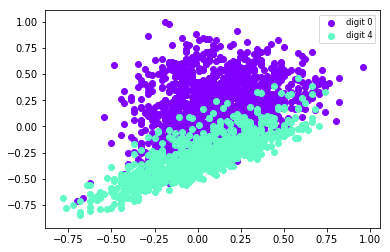

In [3]:
# read data from file 
train_file = "ZipDigits.train.txt"
test_file = "ZipDigits.test.txt"
order = 8
data_set = data_process([train_file,test_file])
# normalize feature
data_set = normalize(data_set)
original_data_set = data_set[:,:]
# draw the number with different color to check the distribution.
colors = cm.rainbow(np.linspace(0, 1,10 ))
for i in range(10):
    if i != 0 and i != 4:
        continue
    index = np.where(data_set[:,0] == i )
    print("The size of digit {} is {}".format(i, len(index[0])))
    plt.scatter(data_set[index,1], data_set[index,2], color=colors[i], label="digit "+str(i))
plt.legend(fontsize='small')
plt.show()

I will choose 475 of digit zero, and 25 of digit four randomly. So I can get 95% positive data points and 5% negative points.

|  | value | number | % in training set |
|---------|---|-----|------------------ |
|Positive | 0 | 475 | 95% | 
|Negative | 4 | 25  |  5% | 



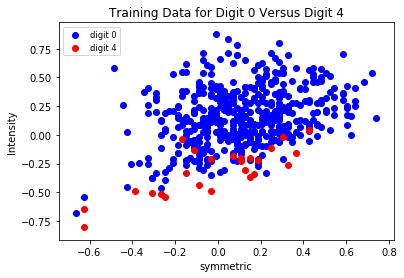

In [4]:
# number of total training data
N = 500
data_set = data_set[np.where( (data_set[:,0] == 0) | (data_set[:,0] == 4) )]
p_train, p_test, n_train, n_test = split_data(data_set)


paras = [[1, p_train, "blue", "0"],  [0, n_train, "red", "4"] ]
for para in paras:
    train = para[1]
    index = np.where(train[:,0] == para[0] )
    plt.scatter(train[index,1], train[index,2], color=para[2], label="digit "+str(para[3]))
plt.title("Training Data for Digit 0 Versus Digit 4")
plt.xlabel("symmetric")
plt.ylabel("Intensity")
plt.legend(fontsize='small')
plt.show()

 ## Choose Logistic Regression
 The objective function of logistic regression. We need to minimial this equation
 $$ E_{in} (\textbf{w}) = \frac{1}{N} \sum^N_{n=1} \ln(1+e^{-y_n\textbf{w}^T\textbf{x}_n}) $$
 I will use library in python to get the training accuracy before resample and after resample
 
 ## Keep reminder: 
 ## Use $y=\pm1$ to train data  
 ## Use $y = 0,1$ to test the model

In [6]:
# training data
train_data_set = np.concatenate((p_train, n_train), 0)
x_train = np.copy(train_data_set)
x_train[:,0] = 1
y_train = np.array(train_data_set[:,0])
y_train[np.where(y_train==0)] = -1
# test data
test_data_set = np.concatenate((p_test, n_test),0)
x_test = np.copy(test_data_set[:,:])
y_test = np.array(test_data_set[:,0])

w = np.zeros(3)

const = 10
old_w = 0
for itr in range(10000):
    g = 0
    for i in range(len(y_train)):
        yx = y_train[i] * x_train[i]
        denominator = (1+e**( y_train[i]*( (w.T.dot(x_train[i])))))
        g += yx / denominator
    g = g/N
    w += const * g
    if itr % 100 == 0:
        # I set a stop point when the difference of old and new weight 
        # is too small
        if abs(norm(w)-norm(old_w)) < 1e-6:
            break
        old_w = np.copy(w)
        
x_test[:,0] = 1
scores = np.dot(x_test, w)
predictions = np.round(sigmoid(scores))
result = np.concatenate((predictions.reshape(len(predictions),1), y_test.reshape(len(y_test),1)),1)
print("Accuracy of our own weight before resample", len(np.where(result[:,0]== result[:,1])[0])/len(result))
 

Accuracy of our own weight 0.7275590551181103


## Use SK-Learn to test our accuracy of result. 

In [7]:
# C is regularization capacity. 1e15 is pretty large number 
# so it seems no regularization.
logisticRegr = LogisticRegression(fit_intercept=True, C=1e15)
logisticRegr.fit(train_data_set[:,1:],train_data_set[:,0])
score = logisticRegr.score(test_data_set[:,1:], test_data_set[:,0])
print("Accuracy from SK-Learn is before resample {}".format(score))

Accuracy from SK-Learn is 0.7275590551181103


/Users/gengruijie/anaconda3.5/anaconda/envs/opencvenv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Oversample the minority class
From above result, we can see the test accuracy is 57%. 

Next part I will oversample the minority class and train again.

In [9]:
# to create new train data set
train_data_set = np.copy(p_train)
for i in range(19):
    train_data_set = np.concatenate((train_data_set, n_train), 0)

logisticRegr = LogisticRegression()
x_train = train_data_set[:,1:]
y_train = np.copy(np.array(train_data_set[:,0]))
# y_train[np.where(y_train == 0)] = -1
# print(y_train)

logisticRegr.fit(x_train, y_train)
logisticRegr.predict(data_set[:,1:])

test_data_set = np.concatenate((p_test, n_test),0)
x_test = test_data_set[:,1:]
y_test = np.array(test_data_set[:,0])
score = logisticRegr.score(x_test, y_test)
print("Predict accuracy from SK-Learn after resample is: {}".format(score))


Predict accuracy: 0.8572178477690289


/Users/gengruijie/anaconda3.5/anaconda/envs/opencvenv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
